In [2]:
import networkx as nx
import numpy as np
import random
random.seed;
import matplotlib.pyplot as plt
import scipy
from scipy import sparse
from scipy.sparse import linalg
import time
import math
from scipy import stats
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from random import shuffle

import sys
sys.path += ['/Package']
from clustering import *

import warnings
warnings.filterwarnings("ignore")

### Function that defines the value of $(1-\mu) \pm f_\alpha\beta$

In [3]:
def f(n,classes,mu,c_in,c_out,theta):
    
    vp = np.zeros(n)
    vm = np.zeros(n)
    
    c = (c_in + c_out)*0.5
    phi = np.mean(theta**2)
    r = (c_in + c_out)/(c_in - c_out)
    
    for i in range(n):
        if classes[i] == 1:
            vp[i] = (1-mu) + (2*np.sqrt(c_in*c_out)/(c_in - c_out))/np.sqrt(c)
            vm[i] = (1-mu) - (2*np.sqrt(c_in*c_out)/(c_in - c_out))/np.sqrt(c)
            
        else:
            vp[i] = -(1-mu) - (2*np.sqrt(c_in*c_out)/(c_in - c_out))/np.sqrt(c) 
            vm[i] = -(1-mu) + (2*np.sqrt(c_in*c_out)/(c_in - c_out))/np.sqrt(c)

    v_norm = np.zeros(n) # normalization of the vector
    for i in range(n):
        r = np.random.uniform(0,1)
        if r < 0.5:
            v_norm[i] = vp[i]
        else:
            v_norm[i] = vm[i]
    if np.linalg.norm(v_norm) != 0:
        vp = vp/np.linalg.norm(v_norm)
        vm = vm/np.linalg.norm(v_norm)
    
    return vp,vm

In [4]:
n = 5000 # size pf the network
n_average = 10 # number of averages
fraction = int(n/2) # number of nodes in the first community
number_sim = 30 # number of simulation points
assortativity = 1 # -1 for disassortative networks

vertices = np.arange(n)
classes = np.zeros(n)
classes[:fraction] = 1

n_clusters = 2


degrees = np.zeros(((number_sim,n_average,n)))
mu = np.zeros(number_sim)
vp = np.zeros((number_sim,n))
vm = np.zeros((number_sim,n))
sgn = np.ones(number_sim)
vsim = np.zeros((number_sim,n))
overlap = np.zeros((number_sim,n_average))

degrees_c = np.zeros(((number_sim,n_average,n)))
mu_c = np.zeros(number_sim)
vp_c = np.zeros((number_sim,n))
vm_c = np.zeros((number_sim,n))
sgn_c = np.ones(number_sim)
overlap_c = np.zeros((number_sim,n_average))

### Vecotr of c_in and c_out points

c_out = 6
c_in = 7
c_in_v = np.zeros(number_sim)
c_out_v = np.zeros(number_sim)
for i in range(number_sim):
    c_in_v[i] = c_in + i
    c_out_v[i] = c_out
    
### generation of the two degree distributions
    
theta_c = np.ones(n)
theta = np.random.uniform(3,10,size = n)**4

theta = theta/np.mean(theta)

In [5]:
'''For the power law distribution: definition of the band limits of the eigenvector'''

for i in range(number_sim):
    c_in = c_in_v[i]
    c_out = c_out_v[i]
    
    r = (c_in + c_out)/(c_in - c_out)
    c = 0.5*(c_in+c_out)
    alpha = (c_in - c_out)/np.sqrt(c)
    if c*np.mean(theta**2) > r**2:
        mu[i] = 1-np.sqrt((c*np.mean(theta**2)-r**2)/(c*np.mean(theta**2)-1))
    else:
        mu[i] = 1

    vp[i],vm[i] = f(n,classes,mu[i],c_in,c_out,theta)    

### Power law distribution

In [7]:
t0 = time.time()

for i in range(number_sim):
    for k in range(n_average):

        c_in = c_in_v[i]
        c_out = c_out_v[i]
        
        A = adj(c_in,c_out,theta,fraction)
        d = np.sum(A.astype(float),axis = 0)
        r = (c_in + c_out)/(c_in - c_out)
        c = (c_in+c_out)/2
        alpha = (c_in - c_out)/np.sqrt(c)
        predict, eigenvalues, X, ov = BH(A,classes,r,assortativity)
        sgn[i] = np.sign(np.mean(X[:,1][:int(n/2)]))

        overlap[i][k] += ov
        
        v = X[:,1].real
        vsim[i] = v

        degrees[i][k] += np.sum(A,axis = 0)
        OUT = 'Completion : i = ' + str(i+1) + '/'+str(number_sim) + ', j = ' + str(k+1) + '/'+str(n_average) + ' Time : ' + str(time.time()-t0)
        sys.stdout.write('\r%s' % OUT)
        sys.stdout.flush()
        
ov_vector = np.sum(overlap, axis = 1)/n_average
var_vector = (np.sum(overlap**2, axis = 1)/n_average - (np.sum(overlap, axis = 1)/n_average)**2)

### Uniform distribution

In [9]:
t0 = time.time()

for i in range(number_sim):
    for k in range(n_average):

        c_in = c_in_v[i]
        c_out = c_out_v[i]
        
        A = adj(c_in,c_out,theta_c,fraction)
        d = np.sum(A.astype(float),axis = 0)
        r = (c_in + c_out)/(c_in - c_out)
        c = (c_in+c_out)/2
        alpha = (c_in - c_out)/np.sqrt(c)
        predict, eigenvalues, X, ov = BH(A,classes,r,assortativity)
        sgn_c[i] = np.sign(np.mean(X[:,1][:int(n/2)]))

        overlap_c[i][k] += ov

        degrees_c[i][k] += np.sum(A,axis = 0)
        OUT = 'Completion : i = ' + str(i+1) + '/'+str(number_sim) + ', j = ' + str(k+1) + '/'+str(n_average) + ' Time : ' + str(time.time()-t0)
        sys.stdout.write('\r%s' % OUT)
        sys.stdout.flush()
        
ov_vector_c = np.sum(overlap_c, axis = 1)/n_average
var_vector_c = (np.sum(overlap_c**2, axis = 1)/n_average - (np.sum(overlap_c, axis = 1)/n_average)**2)

### Behavior of the eigenvector for the power law

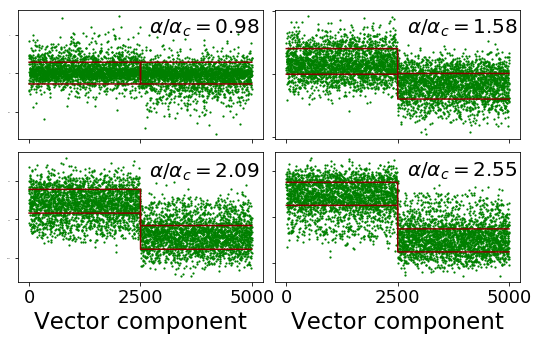

In [9]:
x = range(10)
y = range(10)
alpha = (c_in_v - c_out_v)/(np.sqrt(0.5*(c_in_v+c_out_v))) # vector alpha

n_frames = 3
fig, ax = plt.subplots(nrows=2, ncols=2,figsize = (9,5))
k = 3
sgn = np.zeros(len(vsim))
p = 1
plt.subplots_adjust(hspace=0.1, wspace=0.05)
fs = 15
fs1 = 23
fs2 = 20
ms = 1.2

for row in ax:
    for col in row:
    
        
        col.locator_params(axis='y', nbins=3)
        col.set_xticks([0,2500,5000])
        if k%2 != 0 :
            col.tick_params(labelleft=True)
        else:
            col.tick_params(labelleft=False)
            
        if k < 7:
           col.tick_params(labelbottom=False) 


        sgn[k] = np.sign(np.mean(vsim[k][:100]))
        col.plot(sgn[k]*vsim[k],'o',color = 'g',markersize = ms)
        col.plot(vm[k],color = 'darkred')
        col.plot(vp[k],color = 'darkred')
        if k == 0:
            col.set_ylim(-0.07,0.07)
            col.text(2.7*n/5, 0.22*max(sgn[k]*vsim[k]), r'$\alpha/\alpha_c = $' + str(np.round(alpha[k]/2*np.sqrt(np.mean(theta**2)),2)), fontsize=fs2)
        else:
            col.text(2.7*n/5, 0.7*max(sgn[k]*vsim[k]), r'$\alpha/\alpha_c = $' + str(np.round(alpha[k]/2*np.sqrt(np.mean(theta**2)),2)), fontsize=fs2)
        k += n_frames
        p += 1
        
        
        if k > 9:
            col.set_xlabel('Vector component', fontsize = fs1)
    
            
        col.tick_params(axis="x", labelsize=18)
        col.tick_params(axis="y", labelsize=0)
        
plt.show();

### Theoretical overlap for the power-law

In [12]:
c = 0.5*(c_in_v+c_out)
arg = np.zeros(len(c))
y = np.zeros(len(c))
alpha_c = 2/np.sqrt(np.mean(theta**2))
            
for i in range(len(c)):
    for k in range(n_average):
        d = degrees[i][k]
        c = (c_in_v[i]+c_out_v[i])/2
        r = (c_in_v[i]+c_out_v[i])/(c_in_v[i]-c_out_v[i])
        phi = np.mean(theta**2)
        for j in range(n):
            if phi-(2/alpha[i])**2 > 0:
                y[i]+= 1/(n*n_average)*scipy.special.erf(alpha[i]/np.sqrt(8*c-2*alpha[i]**2)*np.sqrt(degrees[i][k][j])*np.sqrt((c*phi-r**2)/(c*phi-1)))
            else:
                y[i] += 0

y[y<0] = 0

### Theoretical overlap for the uniform distribution

In [13]:
c = 0.5*(c_in_v+c_out)
arg = np.zeros(len(c))
y_c = np.zeros(len(c))
alpha_cc = 2
            
for i in range(len(c)):
    for k in range(n_average):
        d = degrees_c[i][k]
        phi = np.mean(d**2)/np.mean(d)**2
        c = (c_in_v[i]+c_out_v[i])/2
        r = (c_in_v[i]+c_out_v[i])/(c_in_v[i]-c_out_v[i])
        for j in range(n):
            if 1-(2/alpha[i])**2 > 0:
                y_c[i]+= 1/(n*n_average)*scipy.special.erf(alpha[i]/np.sqrt(8*c-2*alpha[i]**2)*np.sqrt(degrees_c[i][k][j])*np.sqrt((c-r**2)/(c-1)))
            else:
                y_c[i] += 0

y_c[y_c<0] = 0

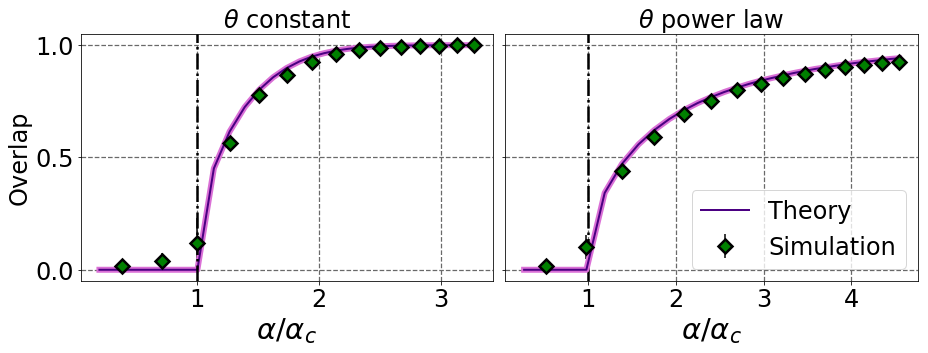

In [13]:
fig = plt.figure(figsize = (15,10))

alpha = (c_in_v-c_out_v)/(np.sqrt(0.5*(c_in_v+c_out_v)))
plt.subplots_adjust(hspace=0.2, wspace=0.03)
ms = 10
lw = 2
fs = 24
lg = 1.25
alpha_cc = 2
alpha_c = 2/np.sqrt(np.mean(theta**2))

plt.subplot(2, 2, 1)
alpha_c_cnst = 2
plt.plot(alpha/alpha_cc,y_c, color = 'orchid',linewidth = 3*lw)
plt.plot(alpha/alpha_cc,y_c, color = 'indigo', label = 'Theory',linewidth = lw)
plt.errorbar(alpha[1::2]/alpha_cc,ov_vector_c[1::2],yerr=np.sqrt(var_vector_c[1::2]),fmt = 'D',color = 'k',markersize = ms,markerfacecolor='green',label = 'Simulation',markeredgewidth = 0.25*ms)
plt.axvline(1,linestyle = '-.', color = 'k',linewidth = 2.5);
plt.title(r'$\theta$ constant',fontsize = fs);
plt.ylabel('Overlap', fontsize=fs)
plt.grid(linestyle = '--', color = 'dimgrey', alpha = 1, linewidth = lg)
plt.xticks([1,2,3])
plt.yticks([0,0.5,1])
plt.tick_params(axis="x", labelsize=fs)
plt.tick_params(axis="y", labelsize=fs)
plt.xlabel(r'$\alpha/\alpha_c$', fontsize=fs+5)

plt.subplot(2, 2, 2)
plt.errorbar(alpha[1::2]/alpha_c,ov_vector[1::2],yerr=np.sqrt(var_vector[1::2]),fmt = 'D',color = 'k',markersize = ms,markerfacecolor='green',label = 'Simulation',markeredgewidth = 0.25*ms)
plt.axvline(1,linestyle = '-.', color = 'k',linewidth = 2.5);
plt.plot(alpha/alpha_c,y, color = 'orchid',linewidth = 3*lw)
plt.plot(alpha/alpha_c,y, color = 'indigo',linewidth = lw, label = 'Theory')
plt.title(r'$\theta$ power law',fontsize = fs);
plt.xlabel(r'$\alpha/\alpha_c$', fontsize=fs+5)
plt.xticks([1,2,3,4])
plt.yticks([0,0.5,1])
plt.ylim(-0.05,1.05)
plt.tick_params(axis="x", labelsize=fs)
plt.tick_params(axis="y", labelsize=fs)
plt.grid(linestyle = '--', color = 'dimgrey', alpha = 1, linewidth = lg)
plt.legend(fontsize = fs)
plt.tick_params(labelleft=False)
plt.show()